## Aim: Visualise sentiment analysis and hate-lexicon.

In [1]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../data/dataset_with_sent_hate.tsv', delimiter='\t', lineterminator='\n')

# Load Skipped IDs (text = NaN)
with open('./src/skipped_ids.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        skipped_ids = row
        
print(len(skipped_ids))

# Remove empty text rows:
print("Initially: ", df.shape)
df = df.loc[~df['id'].isin(skipped_ids)]
print("After: ", df.shape)

print(df['speaker_label'].value_counts())
df.head(3)

915
Initially:  (8124848, 12)
After:  (8123933, 12)
Liberal         4636518
Conservative    3487415
Name: speaker_label, dtype: int64


,id,speaker_id,speaker_label,parent_id,addressee_id,addressee_label,subreddit,text,is_comment,hate_count,compound_VADER,neg_VADER
0,43lpuz,moving-target,Liberal,NaN,NaN,NaN,SandersForPresident,Oh man msnbc is just full on making shit up an...,False,1.0,-0.5574,0.205
1,43lpwo,TaylorSwift2014,Liberal,NaN,NaN,NaN,SandersForPresident,Where online will I be able to view results as...,False,0.0,0.0000,0.000
2,43lq2k,writingtoss,Liberal,NaN,NaN,NaN,SandersForPresident,"On Iowa; or, On, Iowa!",False,0.0,0.0000,0.000


# Plots for Sentiment Analysis:

Text(0.5, 1.0, "Distribution of VADER's compound score (8.1M)")

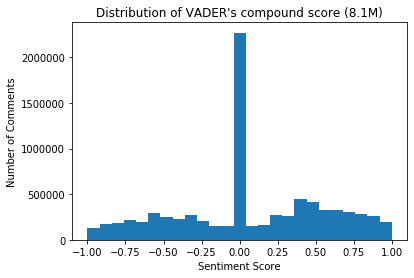

In [3]:
plt.hist(df['compound_VADER'].tolist(), bins=25)
plt.ylabel('Number of Comments')
plt.xlabel('Sentiment Score')
plt.title("Distribution of VADER's compound score (8.1M)")

Text(0.5, 1.0, "Distribution of VADER's neg score (8.1M)")

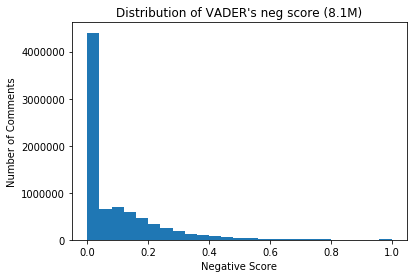

In [4]:
plt.hist(df['neg_VADER'].tolist(), bins=25)
plt.ylabel('Number of Comments')
plt.xlabel('Negative Score')
plt.title("Distribution of VADER's neg score (8.1M)")

#### Using the recommended <a href='https://github.com/cjhutto/vaderSentiment#about-the-scoring'>standardized threshold scores</a> for binning into positive, negative, & neutral:

In [5]:
def f(row):
    if row['compound_VADER'] >= 0.05:
        val = 'positive'
    elif row['compound_VADER'] <= -0.05:
        val = 'negative'
    elif row['compound_VADER'] > -0.05 and row['compound_VADER'] < 0.05:
        val = 'neutral'
    else:
        print("Why! Text = ", row['text'], "Senti-score = ", row['compound_VADER'])
        val = -1000000
    return val

df['sentiment'] = df.apply(f, axis=1)
df.head(3)

,id,speaker_id,speaker_label,parent_id,addressee_id,addressee_label,subreddit,text,is_comment,hate_count,compound_VADER,neg_VADER,sentiment
0,43lpuz,moving-target,Liberal,NaN,NaN,NaN,SandersForPresident,Oh man msnbc is just full on making shit up an...,False,1.0,-0.5574,0.205,negative
1,43lpwo,TaylorSwift2014,Liberal,NaN,NaN,NaN,SandersForPresident,Where online will I be able to view results as...,False,0.0,0.0000,0.000,neutral
2,43lq2k,writingtoss,Liberal,NaN,NaN,NaN,SandersForPresident,"On Iowa; or, On, Iowa!",False,0.0,0.0000,0.000,neutral


#### 1) Only by Speaker Label (8.1 million comments):

Text(0.5, 1.0, 'Sentiment distrbution by Speaker Label (8.1M)')

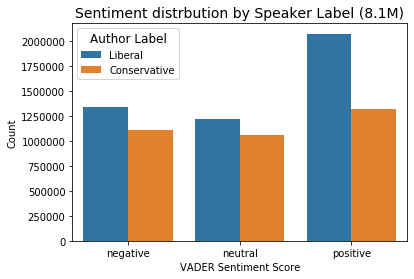

In [6]:
p4 = sns.countplot(x=df['sentiment'], hue=df['speaker_label'], order=("negative", "neutral", "positive"))
p4.set_xlabel('VADER Sentiment Score')
p4.set_ylabel('Count')
p4.legend(title='Author Label', title_fontsize=12)
p4.set_title('Sentiment distrbution by Speaker Label (8.1M)', fontsize=14)

In [7]:
# Remove comments corresponding to unknown addressee(s):
df = df[df['addressee_label'].notna()]
print(df.shape)

def f(row):
    if row['speaker_label'] == 'Liberal' and row['addressee_label'] == 'Conservative':
        val = 'LC'
        
    elif row['speaker_label'] == 'Liberal' and row['addressee_label'] == 'Liberal':
        val = 'LL'
        
    elif row['speaker_label'] == 'Conservative' and row['addressee_label'] == 'Liberal':
        val = 'CL'
        
    elif row['speaker_label'] == 'Conservative' and row['addressee_label'] == 'Conservative':
        val = 'CC'
    else:
        print("Text = ", row['text'])
        val = -1000000
    return val

df['interlocutors'] = df.apply(f, axis=1)
df.head(3)

(2907737, 13)


,id,speaker_id,speaker_label,parent_id,addressee_id,addressee_label,subreddit,text,is_comment,hate_count,compound_VADER,neg_VADER,sentiment,interlocutors
64321,d1fkcdl,alleycatzzz,Liberal,4c716a,cmplxgal,Liberal,SandersForPresident,Has there been any counts as to what the absen...,True,0.0,0.1280,0.038,positive,LL
64323,d1fkcfd,mahakali_overdrive2,Liberal,d1fk7oy,Gummalillan,Liberal,SandersForPresident,"If we don't act now, this could look like Ariz...",True,0.0,0.4411,0.028,positive,LL
64324,d1fkcg3,JustDoinThings,Conservative,4c6w6h,Lightfiend,Conservative,The_Donald,tbqh it is our fault for not preparing for the...,True,0.0,-0.2230,0.061,negative,CC


#### 2) Both by Addressee & Speaker Label (2.9 million comments):

Text(0.5, 1.0, 'Sentiment distribution for Speaker-Addressee (2.9M)')

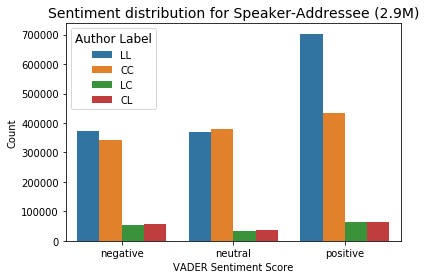

In [8]:
p4 = sns.countplot(x=df['sentiment'], hue=df['interlocutors'], order=("negative", "neutral", "positive"))
p4.set_xlabel('VADER Sentiment Score')
p4.set_ylabel('Count')
p4.legend(title='Author Label', title_fontsize=12)
p4.set_title('Sentiment distribution for Speaker-Addressee (2.9M)', fontsize=14)

Text(0.5, 1.0, 'Sentiment distribution for InGroup/OutGroup (2.9M)')

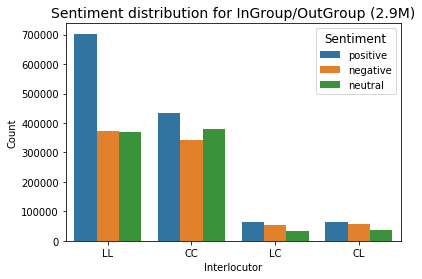

In [9]:
p4 = sns.countplot(x=df['interlocutors'], hue=df['sentiment'], order=("LL", "CC", "LC", "CL"))
p4.set_xlabel('Interlocutor')
p4.set_ylabel('Count')
p4.legend(title='Sentiment', title_fontsize=12)
p4.set_title('Sentiment distribution for InGroup/OutGroup (2.9M)', fontsize=14)

##### Zoom-in for OutGroup:

Text(0.5, 1.0, 'Sentiment distribution only for OutGroup (2.9M)')

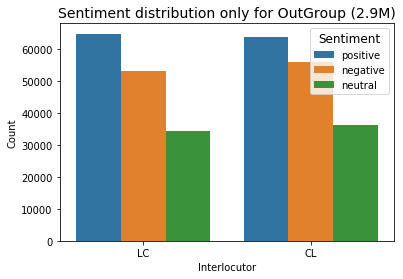

In [10]:
p4 = sns.countplot(x=df['interlocutors'], hue=df['sentiment'], order=("LC", "CL"))
p4.set_xlabel('Interlocutor')
p4.set_ylabel('Count')
p4.legend(title='Sentiment', title_fontsize=12)
p4.set_title('Sentiment distribution only for OutGroup (2.9M)', fontsize=14)

# Plots for Hate Count:

In [3]:
def f(row):
    if row['hate_count'] > 0.0:
        val = 'Present'

    elif row['hate_count'] == 0.0:
        val = 'Absent'
        
    else:
        print("Text = ", row['text'])
        val = -1000000
    return val

df['hate_presence'] = df.apply(f, axis=1)
df.head(3)

,id,speaker_id,speaker_label,parent_id,addressee_id,addressee_label,subreddit,text,is_comment,hate_count,compound_VADER,neg_VADER,hate_presence
0,43lpuz,moving-target,Liberal,NaN,NaN,NaN,SandersForPresident,Oh man msnbc is just full on making shit up an...,False,1.0,-0.5574,0.205,Present
1,43lpwo,TaylorSwift2014,Liberal,NaN,NaN,NaN,SandersForPresident,Where online will I be able to view results as...,False,0.0,0.0000,0.000,Absent
2,43lq2k,writingtoss,Liberal,NaN,NaN,NaN,SandersForPresident,"On Iowa; or, On, Iowa!",False,0.0,0.0000,0.000,Absent


In [4]:
print(df['hate_count'].value_counts())
print(df['hate_presence'].value_counts())

0.0      7103212
1.0       795679
2.0       154664
3.0        41399
4.0        14715
          ...   
50.0           1
49.0           1
704.0          1
480.0          1
38.0           1
Name: hate_count, Length: 73, dtype: int64
Absent     7103212
Present    1020721
Name: hate_presence, dtype: int64


In [5]:
df.loc[df['hate_count']>500]

,id,speaker_id,speaker_label,parent_id,addressee_id,addressee_label,subreddit,text,is_comment,hate_count,compound_VADER,neg_VADER,hate_presence
2021480,d0rjm1c,ShadowBannned,Conservative,NaN,NaN,NaN,4chan,cuck faggot cuck faggot cuck faggot cuck faggo...,True,572.0,-1.0,0.815,Present
2021887,d0rjzly,ShadowBannned,Conservative,NaN,NaN,NaN,4chan,"yes, actually. it's 1000 characters.\n\ncuck f...",True,572.0,-1.0,0.813,Present
5035853,d23d7w5,Isaac923,Conservative,NaN,NaN,NaN,The_Donald,\nFinland Balls Finland Balls Finland Balls Fi...,True,704.0,0.0,0.000,Present


Text(0.5, 1.0, 'Hate-word-usage distrbution by Speaker Label (8.1M)')

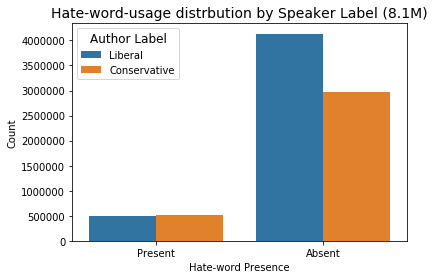

In [6]:
p4 = sns.countplot(x=df['hate_presence'], hue=df['speaker_label'])
p4.set_xlabel('Hate-word Presence')
p4.set_ylabel('Count')
p4.legend(title='Author Label', title_fontsize=12)
p4.set_title('Hate-word-usage distrbution by Speaker Label (8.1M)', fontsize=14)

In [7]:
# Remove comments corresponding to unknown addressee(s):
df = df[df['addressee_label'].notna()]
print(df.shape)

def f(row):
    if row['speaker_label'] == 'Liberal' and row['addressee_label'] == 'Conservative':
        val = 'LC'
        
    elif row['speaker_label'] == 'Liberal' and row['addressee_label'] == 'Liberal':
        val = 'LL'
        
    elif row['speaker_label'] == 'Conservative' and row['addressee_label'] == 'Liberal':
        val = 'CL'
        
    elif row['speaker_label'] == 'Conservative' and row['addressee_label'] == 'Conservative':
        val = 'CC'
    else:
        print("Text = ", row['text'])
        val = -1000000
    return val

df['interlocutors'] = df.apply(f, axis=1)
df.head(3)

(2907737, 13)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,speaker_id,speaker_label,parent_id,addressee_id,addressee_label,subreddit,text,is_comment,hate_count,compound_VADER,neg_VADER,hate_presence,interlocutors
64321,d1fkcdl,alleycatzzz,Liberal,4c716a,cmplxgal,Liberal,SandersForPresident,Has there been any counts as to what the absen...,True,0.0,0.1280,0.038,Absent,LL
64323,d1fkcfd,mahakali_overdrive2,Liberal,d1fk7oy,Gummalillan,Liberal,SandersForPresident,"If we don't act now, this could look like Ariz...",True,0.0,0.4411,0.028,Absent,LL
64324,d1fkcg3,JustDoinThings,Conservative,4c6w6h,Lightfiend,Conservative,The_Donald,tbqh it is our fault for not preparing for the...,True,0.0,-0.2230,0.061,Absent,CC


Text(0.5, 1.0, 'Hate-word-usage distribution for InGroup & OutGroup (2.9M)')

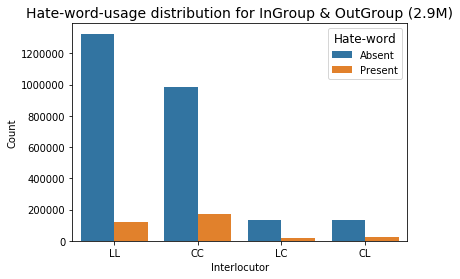

In [9]:
p4 = sns.countplot(x=df['interlocutors'], hue=df['hate_presence'], order=("LL", "CC", "LC", "CL"))
p4.set_xlabel('Interlocutor')
p4.set_ylabel('Count')
p4.legend(title='Hate-word', title_fontsize=12)
p4.set_title('Hate-word-usage distribution for InGroup & OutGroup (2.9M)', fontsize=14)

Text(0.5, 1.0, 'Hate-word-usage distribution only for OutGroup (2.9M)')

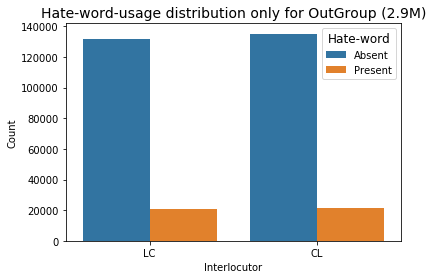

In [10]:
p4 = sns.countplot(x=df['interlocutors'], hue=df['hate_presence'], order=("LC", "CL"))
p4.set_xlabel('Interlocutor')
p4.set_ylabel('Count')
p4.legend(title='Hate-word', title_fontsize=12)
p4.set_title('Hate-word-usage distribution only for OutGroup (2.9M)', fontsize=14)

# fin.